In [1]:
import os, sys
import numpy as np
import corner

sys.path.append('../')
import py21cmfish as p21fish

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mathtext as mathtext
import matplotlib.lines as mlines

%matplotlib inline

plt.style.use(['default','seaborn','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['figure.figsize'] = (4,3)
mpl.rcParams['figure.dpi'] = 150

if os.path.exists(os.environ['WORK_DIR']+'/code/matplotlibrc'):
    from matplotlib import rc_file
    rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

    mathtext.FontConstantsBase.sup1 = 0.5
    mathtext.FontConstantsBase.sub1 = 0.2
    mathtext.FontConstantsBase.sub2 = 0.2

In [2]:
# Color palette
from palettable.tableau import Tableau_20, ColorBlind_10
cols = ColorBlind_10.hex_colors

col_pess  = cols[6]
col_mod   = cols[0]
col_alpha = 'k'
col_mcmc  = cols[3]
col_P19   = cols[1]

In [3]:
%load_ext autoreload
%autoreload 2

# 21cmfish examples

This notebook loads and plots example posteriors based on the 21cm power spectrum.

To run the notebook you must first unpack the data directories in `/examples/`

1. [EOS21 - CDM fiducial with pop II and pop III galaxies](#EOS21)
2. [Comparison with Park+19](#Comparison-to-Park+19)
3. [Adding your own new parameter](#Adding-a-new-parameter)

In [4]:
examples_dir = p21fish.base_path+'examples/'
data_dir     = examples_dir+'data/'
noise_dir    = data_dir+'21cmSense_noise/'

# EOS21

This is a fiducial case from [Munoz+2021](#) with CDM, and with both pop II and pop III galaxies.

In [5]:
# Find the parameters we varied and fiducials from the config file
# but you could also list these yourself (especially if you want to change the order)
astro_params_vary, astro_params_fid = p21fish.get_params_fid(
                                        config_file=p21fish.base_path+'21cmFAST_config_files/EoS_mini.config')

print('Varying parameters:',astro_params_vary)
print('Fiducial parameter values:',astro_params_fid)

assert type(astro_params_vary) == list, 'astro_params_vary must be a list'
assert type(astro_params_fid) == dict, 'astro_params_vary must be a dict'

Varying parameters: ['ALPHA_STAR', 'F_STAR10', 'ALPHA_ESC', 'F_ESC10', 'ALPHA_STAR_MINI', 'F_STAR7_MINI', 'F_ESC7_MINI', 'L_X', 'NU_X_THRESH', 'A_LW']
Fiducial parameter values: {'ALPHA_ESC': -0.3, 'F_ESC10': -1.35, 'ALPHA_STAR': 0.5, 'F_STAR10': -1.25, 't_STAR': 0.5, 'F_STAR7_MINI': -2.5, 'ALPHA_STAR_MINI': 0.0, 'F_ESC7_MINI': -1.35, 'L_X': 40.5, 'L_X_MINI': 40.5, 'NU_X_THRESH': 500.0, 'A_VCB': 1.0, 'A_LW': 2.0}


## Load parameters

### Moderate noise

In [6]:
# Load each parameter into a dictionary
params_EoS = {}
astro_params_vary_EoS = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 
                         'F_STAR7_MINI', 'ALPHA_STAR_MINI', 'F_ESC7_MINI', 'L_X', 'NU_X_THRESH', 'A_LW']

for param in astro_params_vary_EoS:
    params_EoS[param] = p21fish.Parameter(param=param, 
                                          output_dir=data_dir+'EOS21/', 
                                          PS_err_dir=noise_dir+'21cmSense_fid_EOS21/',
                                          clobber=False, Park19=None,
                                          vb=False)

########### fisher set up for F_STAR10
Fiducial: F_STAR10=-1.25
########### fisher set up for ALPHA_STAR
Fiducial: ALPHA_STAR=0.5
########### fisher set up for F_ESC10
Fiducial: F_ESC10=-1.35
########### fisher set up for ALPHA_ESC
Fiducial: ALPHA_ESC=-0.3
########### fisher set up for F_STAR7_MINI
Fiducial: F_STAR7_MINI=-2.5
########### fisher set up for ALPHA_STAR_MINI
Fiducial: ALPHA_STAR_MINI=0.0
########### fisher set up for F_ESC7_MINI
Fiducial: F_ESC7_MINI=-1.35
########### fisher set up for L_X
Fiducial: L_X=40.5
########### fisher set up for NU_X_THRESH
Fiducial: NU_X_THRESH=500.0
########### fisher set up for A_LW
Fiducial: A_LW=2.0


### Pessimistic noise

In [7]:
# Load each parameter into a dictionary
params_EoS_pess = {}

for param in astro_params_vary_EoS:
    params_EoS_pess[param] = p21fish.Parameter(param=param, 
                                          output_dir=data_dir+'EOS21/', 
                                          PS_err_dir=noise_dir+'21cmSense_pess_EOS21/',
                                          clobber=False, Park19=None,
                                          vb=False)

########### fisher set up for F_STAR10
Fiducial: F_STAR10=-1.25
########### fisher set up for ALPHA_STAR
Fiducial: ALPHA_STAR=0.5
########### fisher set up for F_ESC10
Fiducial: F_ESC10=-1.35
########### fisher set up for ALPHA_ESC
Fiducial: ALPHA_ESC=-0.3
########### fisher set up for F_STAR7_MINI
Fiducial: F_STAR7_MINI=-2.5
########### fisher set up for ALPHA_STAR_MINI
Fiducial: ALPHA_STAR_MINI=0.0
########### fisher set up for F_ESC7_MINI
Fiducial: F_ESC7_MINI=-1.35
########### fisher set up for L_X
Fiducial: L_X=40.5
########### fisher set up for NU_X_THRESH
Fiducial: NU_X_THRESH=500.0
########### fisher set up for A_LW
Fiducial: A_LW=2.0


## Fisher matrix analysis

`make_fisher_matrix()` creates the Fisher matrix and its inverse from a Parameters dictionary. The resulting ellipses can be plotted with `plot_triangle()`.

In [8]:
Fij_matrix_PS, Finv_PS = p21fish.make_fisher_matrix(params_EoS, fisher_params=astro_params_vary_EoS, 
                                                     hpeak=0.0, obs='PS',
                                                     k_min=0.1, k_max=1, 
                                                     z_min=5., z_max=30., 
                                                     sigma_mod_frac=0.2,
                                                     add_sigma_poisson=True)

fid_params = np.array([astro_params_fid[param] for param in params_EoS])
fid_labels = np.array([p21fish.astro_params_labels[param] for param in params_EoS])

PS shape: (23, 24)


generating new axis


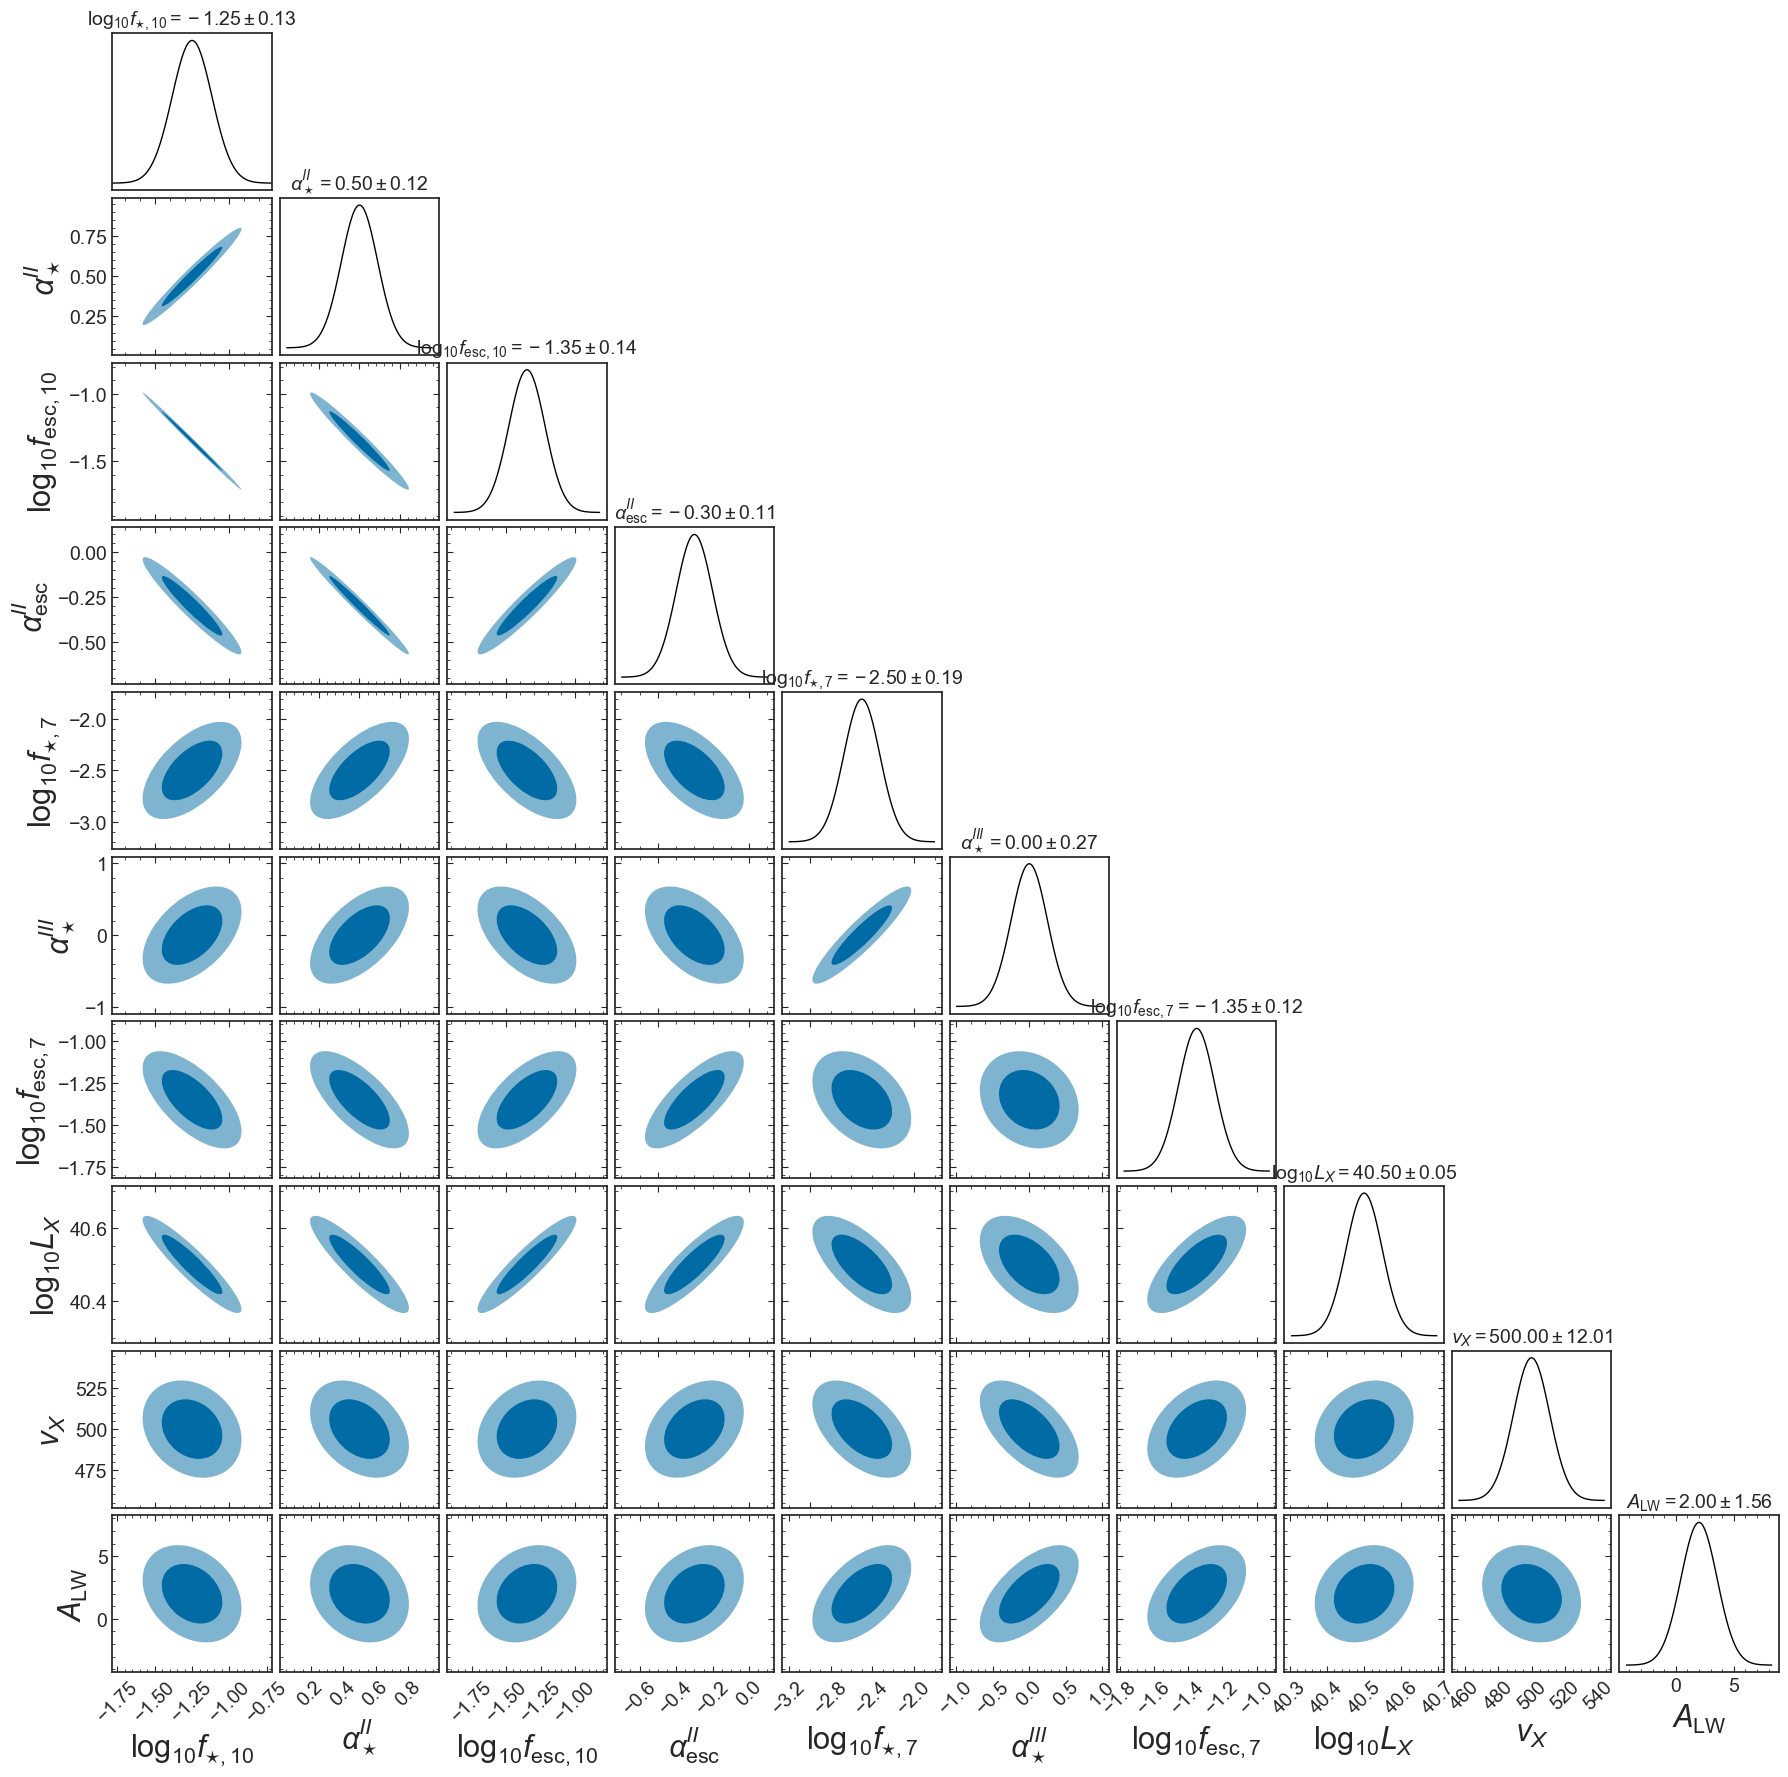

In [9]:
p21fish.plot_triangle(params=astro_params_vary_EoS, 
                      fiducial=fid_params,
                      labels=fid_labels,
                      cov=Finv_PS,
                      ellipse_color=col_mod,
                      title_fontsize=14,
                      xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                      ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                      fig_kwargs={'figsize':(18,18)});

plt.savefig(examples_dir+'corner_EoS_mini_fisher.png', bbox_inches='tight')

## Add a prior

E.g. [Park+2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484..933P/abstract) find $\sigma(\alpha_\star^{II}) \approx 0.07$.

To add a prior, we can add 1/$\sigma^2$ to the diagonal element for that parameter (e.g. [Coe 2009](arXiv:0906.4123))

ALPHA_STAR is at index=1


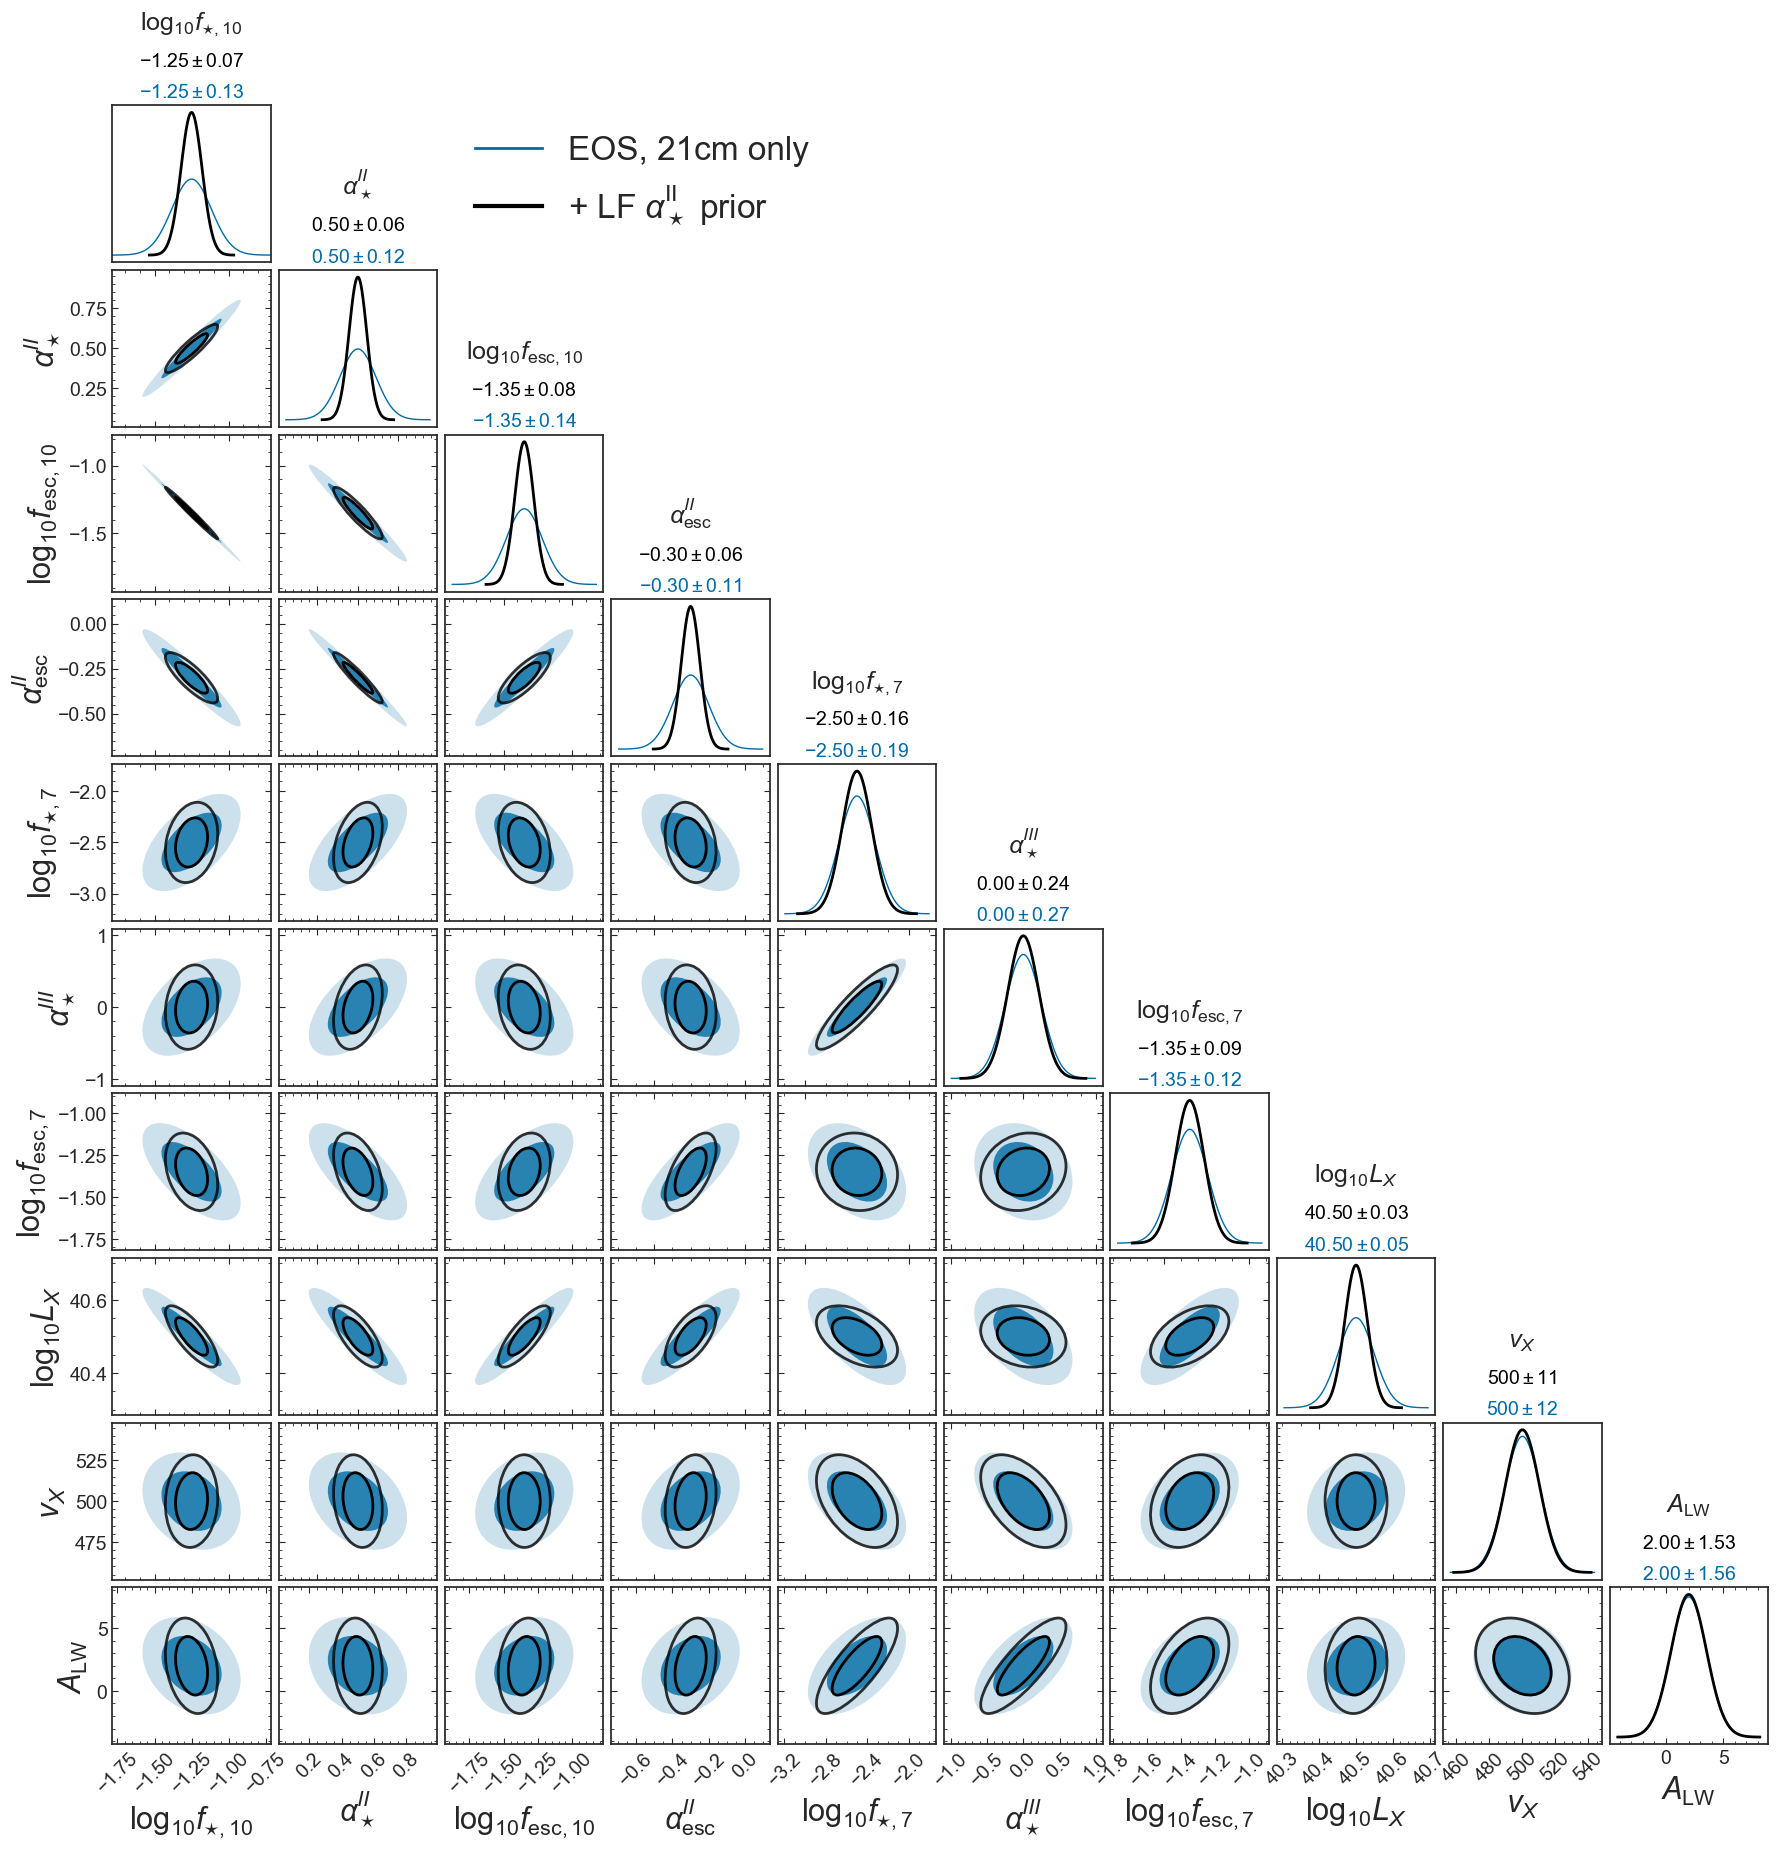

In [10]:
sigma_alpha_star_II = 0.07
idx_alpha_star = list(params_EoS).index("ALPHA_STAR")
print(f'ALPHA_STAR is at index={idx_alpha_star}')
Fij_matrix_PS_alpha_star_prior = Fij_matrix_PS.copy()
Fij_matrix_PS_alpha_star_prior[idx_alpha_star,idx_alpha_star] += 1/sigma_alpha_star_II**2.

Finv_alpha_star_prior = np.linalg.inv(Fij_matrix_PS_alpha_star_prior)

fig, ax = plt.subplots(len(fid_params), len(fid_params), figsize=(18,18))
cols = [col_mod, col_alpha]

for i, cov in enumerate([Finv_PS, Finv_alpha_star_prior]):

    col = cols[i]    
    if i == 0:
        # No prior
        resize_lims=True
        ellipse_color=col
        ellipse_kwargs=[{'alpha':0.8},{'alpha':0.2}]
        plot1D_kwargs={'c':col, 'lw':1}
    else:
        # with prior
        ls='solid'
        resize_lims=False
        ellipse_color='None'
        ellipse_kwargs=[{'edgecolor':col,'lw':2,'ls':ls},
                      {'edgecolor':col,'lw':2,'ls':ls,'alpha':0.8}]
        plot1D_kwargs={'c':col, 'lw':2, 'ls':ls}
        
    p21fish.plot_triangle(params=astro_params_vary_EoS, 
                          fiducial=fid_params,
                          labels=fid_labels,
                          cov=cov,
                          ellipse_color=ellipse_color,
                          ellipse_kwargs=ellipse_kwargs,
                          plot1D_kwargs=plot1D_kwargs,
                          resize_lims=resize_lims,
                          title_fontsize=14,
                          xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ax=ax, fig=fig);

    p21fish.title_double_ellipses(axes=ax, labels=fid_labels,
               med=fid_params, sigma=np.sqrt(cov.diagonal()),
               title_fontsize=18, title_pad=55,
               vspace=i/5,
               color=col
               )

no_prior = mlines.Line2D([], [], color=col_mod, lw=2, label='EOS, 21cm only')
w_prior  = mlines.Line2D([], [], color=col_alpha, lw=3, ls=ls, label=r'+ LF $\alpha_\star^\mathrm{II}$ prior')

ax[0,2].legend(handles=[no_prior, w_prior], loc='upper left', fontsize=24)

plt.savefig(examples_dir+'corner_EoS_mini_fisher_ALPHA_STAR_prior.png', bbox_inches='tight')

# Comparison to Park+19

Compare Fisher matrix with [Park+2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484..933P/abstract) fiducial to their MCMC (21cm power spectrum only)

In [11]:
output_dir_Park19 = data_dir+'Park19/'
PS_err_dir_Park19 = noise_dir+'21cmSense_noise_Park19/'
        
astro_params_vary_Park19, astro_params_fid_Park19 = p21fish.get_params_fid(
                                                    config_file=p21fish.base_path+'21cmFAST_config_files/Park19.config')

# Reorder to match Park+19
astro_params_vary_Park19 = ['F_STAR10', 'ALPHA_STAR',
                             'F_ESC10', 'ALPHA_ESC', 
                             'M_TURN', 't_STAR', 
                             'L_X', 'NU_X_THRESH']

In [12]:
# Load parameters
params_Park19 = {}
for param in astro_params_vary_Park19:
        
    params_Park19[param] = p21fish.Parameter(param=param, 
                                             output_dir=output_dir_Park19,
                                             HII_DIM=128, BOX_LEN=250,
                                             min_redshift=5.9,
                                             PS_err_dir=PS_err_dir_Park19,
                                             clobber=False, Park19='real',
                                             vb=False)

########### fisher set up for F_STAR10
Fiducial: F_STAR10=-1.3
########### fisher set up for ALPHA_STAR
Fiducial: ALPHA_STAR=0.5
########### fisher set up for F_ESC10
Fiducial: F_ESC10=-1.0
########### fisher set up for ALPHA_ESC
Fiducial: ALPHA_ESC=-0.5
########### fisher set up for M_TURN
Fiducial: M_TURN=8.7
########### fisher set up for t_STAR
Fiducial: t_STAR=0.5
########### fisher set up for L_X
Fiducial: L_X=40.5
########### fisher set up for NU_X_THRESH
Fiducial: NU_X_THRESH=500.0


## Make Fisher matrix

In [13]:
Fij_matrix_PS_Park19, Finv_PS_Park19 = p21fish.make_fisher_matrix(params_Park19, 
                                                                fisher_params=astro_params_vary_Park19, 
                                                                hpeak=0.0, obs='PS',
                                                                k_min=0.1, k_max=1, 
                                                                z_min=5.7, z_max=30., 
                                                                sigma_mod_frac=0.2,
                                                                cosmo_key='CDM',
                                                                add_sigma_poisson=True) 

fid_params_Park19 = np.array([astro_params_fid_Park19[param] for param in params_Park19])
fid_labels_Park19 = np.array([p21fish.astro_params_labels[param] for param in params_Park19])

PS shape: (12, 23)


## Load Park19 chains and compare

Load their 21cm-only chains and compare the contours

### Plot 1+2 sigma CI

['F_STAR10' 'ALPHA_STAR' 'F_ESC10' 'ALPHA_ESC' 'M_TURN' 't_STAR' 'L_X'
 'E0']


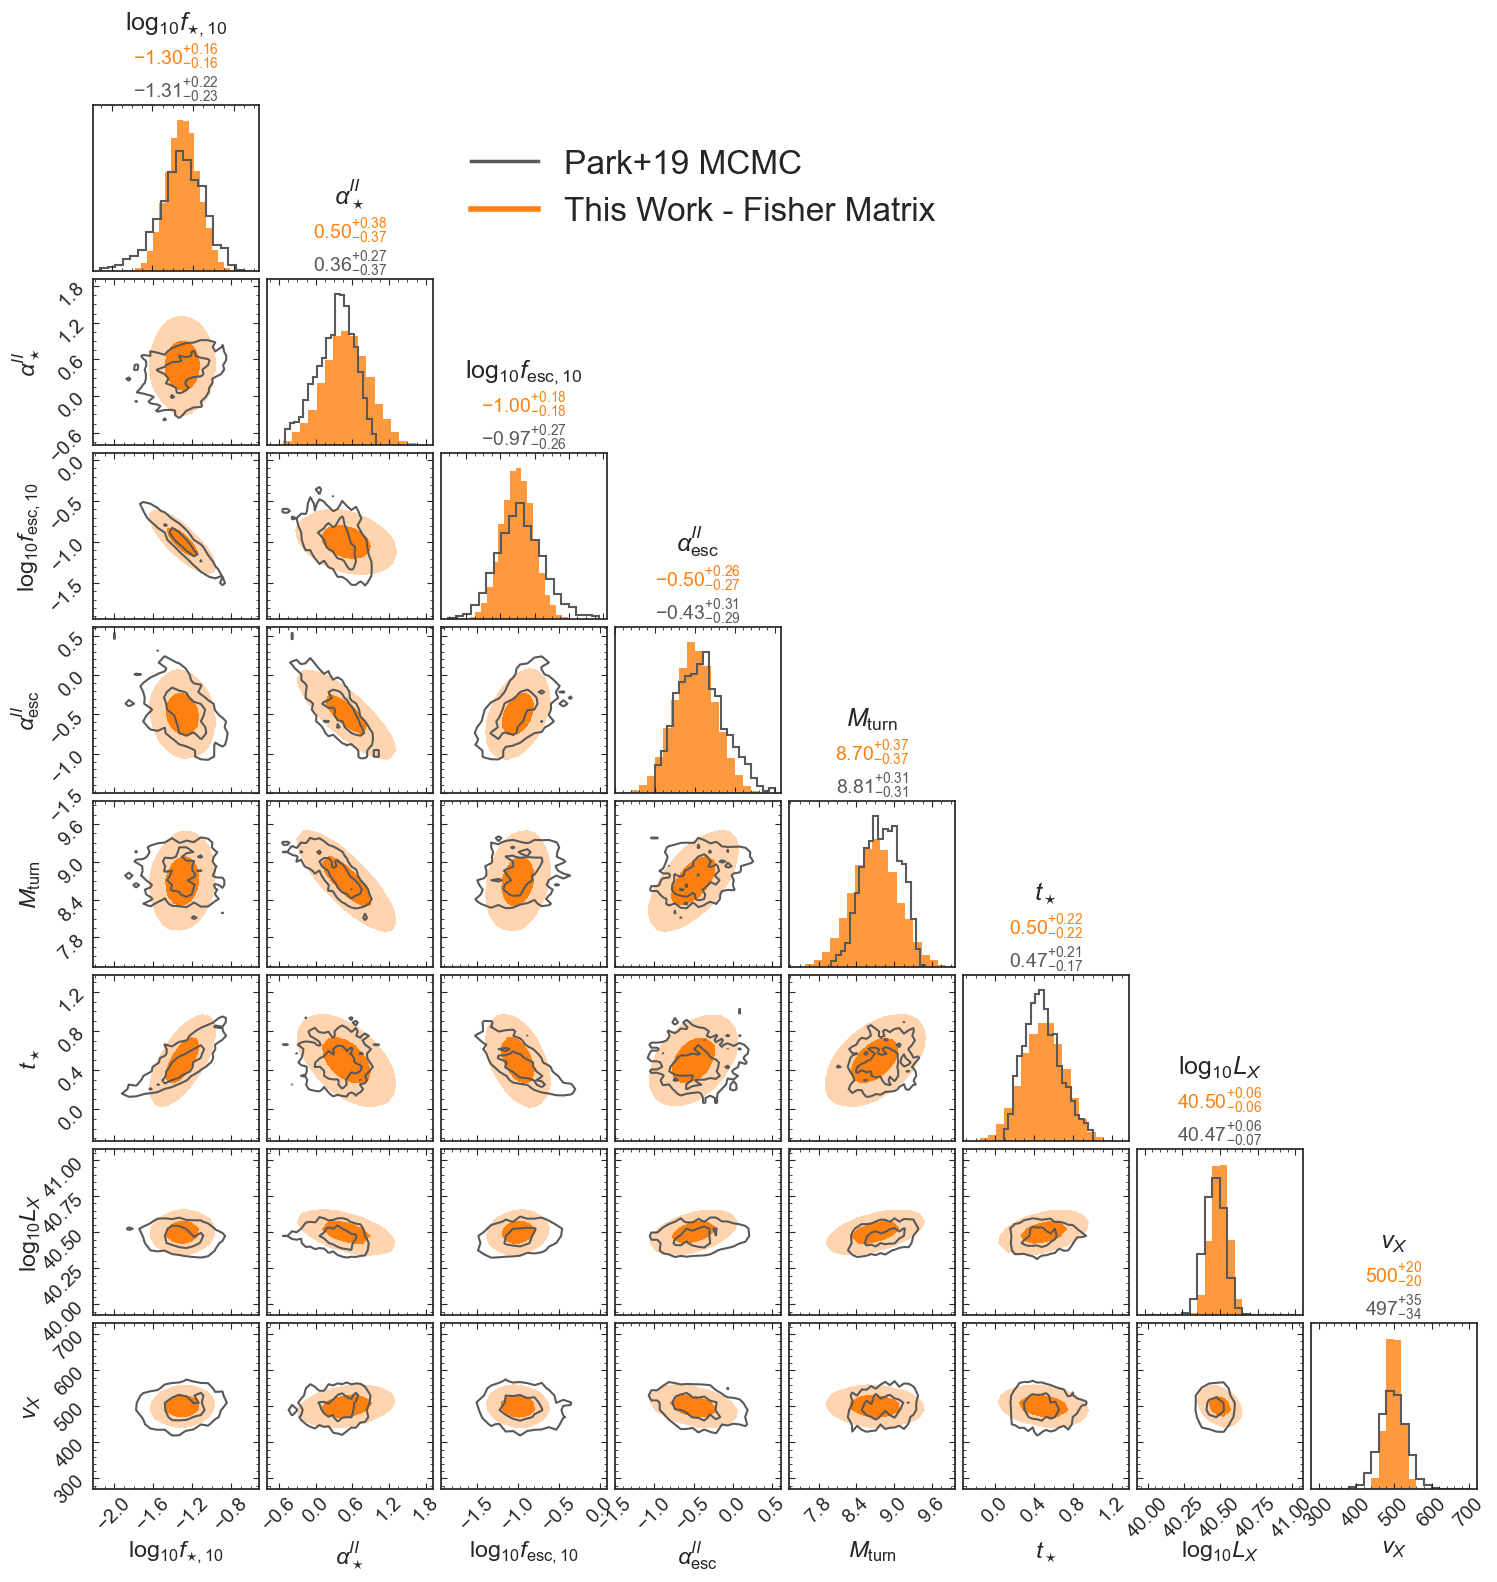

In [14]:
Park19_chains = np.load(f'{output_dir_Park19}Park19_chains.npz')
print(Park19_chains['params'])

# Make posteriors from the covariance matrix
mean = fid_params_Park19.copy()
cov  = Finv_PS_Park19.copy()
fisher_chain = np.random.multivariate_normal(mean, cov, size=10000)

# Corner plot
fig = plt.figure(figsize=(15,15))

colors = [col_mcmc,col_P19]
lws = [1.5,3]

# Plot 2 sigma confidence interval (https://corner.readthedocs.io/en/latest/pages/sigmas.html)
levels = 1.0 - np.exp(-0.5 * np.array([1,2,]) ** 2)
    
for cc, chain in enumerate([Park19_chains['chains'],fisher_chain]):

    if cc == 0:
        # MCMC
        ls='solid'
        lw=lws[cc]
        hist_kwargs = {'lw':lw,'ls':ls,'density':True}
        color=colors[cc]
        smooth=None
        fill_contours    = False
        no_fill_contours = True
        contour_kwargs = {'linewidths':lw,'linestyles':ls}
        contourf_kwargs={}
        zorder=10
    else:
        # fisher
        ls='solid'
        lw=lws[cc]
        hist_kwargs = {'lw':lw,'density':True,'histtype':'stepfilled', 'alpha':0.8}
        fill_contours=True
        no_fill_contours=False
        color=colors[cc]
        smooth=1
        contour_kwargs = {'linewidths':0.}
        contourf_kwargs = {}
        zorder=0

    corner.corner(chain, fig=fig,              
                labels=fid_labels_Park19,
                smooth=smooth,
                color=color, use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                no_fill_contours=no_fill_contours, fill_contours=fill_contours,
                hist_kwargs=hist_kwargs,
                contour_kwargs=contour_kwargs,contourf_kwargs=contourf_kwargs,
                levels=levels,
                range=[1,1,1,1,1,1,(40.,41.),(300,700)], # throws out a couple of outlier points in the chains [better for Lx]
                show_titles=True,
                zorder=zorder
                );

    # Format the quantile display
    ax = np.reshape(fig.axes, (chain.shape[1],chain.shape[1]))

    p21fish.title_double_ellipses(axes=ax, labels=fid_labels_Park19,
                   chain=chain, 
                   med=None, sigma=None,
                   title_fontsize=18, title_pad=55,
                   vspace=cc/5,
                   color=color
                   )

lab_P19 = mlines.Line2D([], [], color=col_mcmc, ls='solid', lw=lws[0]+1, label='Park+19 MCMC')
lab_TW  = mlines.Line2D([], [], color=col_P19, lw=lws[1]+1, label=r'This Work - Fisher Matrix')

fig.get_axes()[2].legend(handles=[lab_P19, lab_TW], loc='center left', fontsize=24)

plt.savefig(examples_dir+'corner_Park19_fisher_compare_2sigma.png', bbox_inches='tight')

# Adding a new parameter

If you want to add your own new parameter, you should:

1. Create lightcones varying that parameter.
    1. Create a config file for the parameters you want to change (take one of the examples in `../21cmFAST_config_files/` and replace the `astro_params_vary` list with your list of new parameters.
    2. Note that the fiducial parameter value for your new parameter will be the 21cmFAST default unless the fiducial value is specified in the config file. If you want a non-default fiducial parameter value you will need to create a new set of lightcones with your parameter's fiducial included in `astro_params`.
    3. Create the lightcones using `scripts/make_lightcones_for_fisher.py`
2. Load your new parameter by adding it to the dictionary [as above](#EOS21)

See more details on running `scripts/make_lightcones_for_fisher.py` in the [docs](https://21cmfish.readthedocs.io/en/latest/usage.html) 